# SIGIR

## Imports and configuration

In [1]:
from math import nan, isnan
from pathlib import Path
from typing import Sequence

from matplotlib.ticker import PercentFormatter
from numpy import stack, sign
from numpy.typing import NDArray
from pandas import read_json, DataFrame, concat, Categorical, read_csv
from pyterrier.datasets import get_dataset
from pyterrier.io import read_results
from seaborn import FacetGrid, lineplot, color_palette
from tqdm.auto import tqdm

from axioms.axiom import (
    Axiom,
    # Adapted axioms
    GEN_TFC1,
    GEN_LNC1,
    GEN_TF_LNC,
    GEN_REG,
    GEN_AND,
    GEN_DIV,
    GEN_STMC1,
    GEN_STMC2,
    GEN_PROX1,
    GEN_PROX2,
    GEN_PROX3,
    GEN_PROX4,
    GEN_PROX5,
    GEN_aSL,
    # Generation-specific axioms
    CLAR1,
    CLAR2,
    CONS3,
    CONS2,
    CONS1,
    CORR1,
    COV1,
    COV2,
    COV3,
    COH1,
    COH2,
    # Oracle axioms
    TrecRagNuggetAxiom,
    TrecRagCrowdAxiom,
    # Utility axioms
    MajorityVoteAxiom,
    SumAxiom,
    # Original axioms
    TrecRagLlmOrigAxiom,
)
from axioms.model import GenerationInput, GenerationOutput
from axioms.tools import KeyBertAspectExtraction, SpacyEntitiesAspectExtraction

2025-01-24 00:50:21.113037: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-24 00:50:21.184801: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1737676221.213647  576309 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1737676221.222587  576309 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-24 00:50:21.288827: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
cache_path = Path("../data/cache/")

## Datasets

In [3]:
rag_assignments_path = Path("../data/nugget_assignment.20241108.jl")
rag_crowd_responses_path = Path("../data/crowd/responses.jsonl.gz")
rag_crowd_ratings_path = Path("../data/crowd/ratings.jsonl.gz")

In [4]:
def read_rag_assignments_outputs_df() -> DataFrame:
    df = read_json(rag_assignments_path, lines=True)
    df.drop(columns=["response_length", "nuggets"], inplace=True)
    df["query"] = df["query"].fillna("")
    df["answer_text"] = df["answer_text"].fillna("")
    df.rename(columns={"run_id": "name", "answer_text": "text"}, inplace=True)
    df["context"] = nan
    return df[["qid", "query", "context", "name", "text"]]

# read_rag_assignments_outputs_df()

In [5]:
def read_rag_crowd_outputs_df() -> DataFrame:
    df = read_json(rag_crowd_responses_path, lines=True)

    df_ratings = read_json(rag_crowd_ratings_path, lines=True)
    df = df[df["topic"].isin(df_ratings["query_id"])]

    df["name"] = df["kind"] + "-" + df["style"]
    # df = df[df["kind"] == "human"]
    df.rename(
        columns={"topic": "qid", "references_texts": "context", "raw_text": "text"},
        inplace=True,
    )

    return df[["qid", "query", "context", "name", "text"]]


# read_rag_crowd_outputs_df()

In [6]:
def to_inputs_outputs(df: DataFrame) -> list[tuple[GenerationInput, list[GenerationOutput]]]:
    data: list[tuple[GenerationInput, list[GenerationOutput]]] = []
    runs = sorted(df["name"].unique())
    for (query_id, query), df_query in df.groupby(
        ["qid", "query"], group_keys=False, sort=False, as_index=False,
    ):
        contexts = {
            tuple(row["context"]) 
            if isinstance(row["context"], Sequence) else None
            for _, row in df_query.iterrows()
        }
        if len(contexts) > 1:
            raise ValueError(f"Multiple contexts for query {query_id}: {'; '.join(contexts)}")
        context = next(iter(contexts))
        input = GenerationInput(
            id=query_id,
            text=query,
            context=context,
        )
        df_query = df_query.drop(columns=["qid", "query"])
        outputs = {
            row["name"]: GenerationOutput(
                id=row["name"],
                text=row["text"],
            )
            for _, row in df_query.iterrows()
        }
        data.append(
            (
                input,
                [
                    outputs.get(
                        run,
                        GenerationOutput(
                            id=run,
                            text="",
                        ),
                    )
                    for run in runs
                ],
            )
        )
    return data

In [7]:
# print(to_inputs_outputs(read_rag_assignments_outputs_df())[:3])

In [8]:
# print(to_inputs_outputs(read_rag_crowd_outputs_df())[:3])

## Oracle axiom preferences

In [9]:
rag_oracle_axioms: list[tuple[str, Axiom[GenerationInput, GenerationOutput]]] = [
    *[
        (
            f"ORACLE-NUGGET-{score_type.upper()}{"-STRICT" if strict else ''}{f'-{margin_fraction:.1f}' if margin_fraction > 0.0 else ''}",
            TrecRagNuggetAxiom(
                assignments_path=rag_assignments_path,
                score_type=score_type,
                strict=False,
                margin_fraction=margin_fraction,
            ),
            "assignments",
        )
        for score_type in (
            "all",
            "vital",
            "weighted"
        )
        for strict in (
            True,
            False,
        )
        for margin_fraction in (
            0.0,
            # 0.1,
        )
    ],
    *[
        (
            f"ORACLE-CROWD-{utility_type.upper().replace(' ', '-')}{f'-{margin_fraction:.1f}' if margin_fraction > 0.0 else ''}",
            TrecRagCrowdAxiom(
                responses_path=rag_crowd_responses_path,
                ratings_path=rag_crowd_ratings_path,
                utility_type=utility_type,
                margin_fraction=margin_fraction,
            ),
            "crowd",
        )
        for utility_type in (
            "overall",
            "logical coherence",
            "stylistic coherence",
            "coherence",
            "internal consistency",
            "consistency",
            "topical correctness",
            "correctness",
            "broad coverage",
            "deep coverage",
            "coverage",
        )
        for margin_fraction in (
            0.0,
            # 0.1,
        )
    ],
]
rag_oracle_axioms = [
    (name, axiom.cached(cache_path / "axioms" / f"{name}.cache"), run_type)
    for name, axiom, run_type in rag_oracle_axioms
]

In [ ]:
rag_oracle_prefs = [
    (name, data_run_type, stack(
        [
            axiom.preferences(input, outputs)
            for input, outputs in tqdm(data, desc=name, unit="query")
        ]
    ))
    for data, data_run_type in (
        (to_inputs_outputs(read_rag_assignments_outputs_df()), "assignments"),
        (to_inputs_outputs(read_rag_crowd_outputs_df()), "crowd"),
    )
    for name, axiom, axiom_run_type in tqdm(rag_oracle_axioms, desc=f"Axioms: {data_run_type}", unit="axiom")
    if data_run_type == axiom_run_type
]

## Adapted retrieval axiom preferences

In [11]:
rag_retrieval_axioms: list[tuple[str, Axiom[GenerationInput, GenerationOutput]]] = [
    ("GEN-TFC1", GEN_TFC1()),
    ("GEN-LNC1", GEN_LNC1()),
    ("GEN-REG", GEN_REG()),
    ("GEN-AND", GEN_AND()),
    ("GEN-DIV", GEN_DIV()),
    ("GEN-STMC1", GEN_STMC1()),
    ("GEN-STMC2", GEN_STMC2()),
    ("GEN-PROX1", GEN_PROX1()),
    ("GEN-PROX2", GEN_PROX2()),
    ("GEN-PROX3", GEN_PROX3()),
    ("GEN-PROX4", GEN_PROX4()),
    ("GEN-PROX5", GEN_PROX5()),
    ("GEN-aSL", GEN_aSL()),
    ("GEN-TF-LNC", GEN_TF_LNC()),
]
rag_retrieval_axioms = [
    (name, axiom.cached(cache_path / "axioms" / f"{name}.cache"))
    for name, axiom in rag_retrieval_axioms
]

In [ ]:
rag_retrieval_axiom_prefs = [
    (name, data_run_type, stack(
        [
            axiom.preferences(input, outputs)
            for input, outputs in tqdm(data, desc=name, unit="query")
        ]
    ))
    for data, data_run_type in (
        (to_inputs_outputs(read_rag_assignments_outputs_df()), "assignments"),
        (to_inputs_outputs(read_rag_crowd_outputs_df()), "crowd"),
    )
    for name, axiom in tqdm(rag_retrieval_axioms, desc="Axioms", unit="axiom")
]

## New generation axiom preferences

In [13]:
key_bert = KeyBertAspectExtraction(
    ngram_range=(1, 2),
)

In [14]:
spacy_ent = SpacyEntitiesAspectExtraction()

In [15]:
rag_generation_axioms: list[tuple[str, Axiom[GenerationInput, GenerationOutput]]] = [
    #
    # Coherence axioms
    ("COH1-0.75", COH1(margin_fraction=0.75)),
    ("COH2-0.75", COH2(margin_fraction=0.75)),
    #
    # Coverage axioms
    ("COV1-SE-0.5", COV1(aspect_extraction=spacy_ent, margin_fraction=0.5)),
    ("COV2-SE-0.5", COV2(aspect_extraction=spacy_ent, margin_fraction=0.5)),
    ("COV3-SE-0.5", COV3(aspect_extraction=spacy_ent, margin_fraction=0.5)),
    #
    # Consistency axioms
    ("CONS1-SE-0.5", CONS1(aspect_extraction=spacy_ent, margin_fraction=0.5)),
    ("CONS2-0.5", CONS2(margin_fraction=0.5)),
    ("CONS3-0.5", CONS3(margin_fraction=0.5)),
    #
    # Correctness axioms
    ("CORR1-0.75", CORR1(margin_fraction=0.75)),
    #
    # Clarity axioms
    ("CLAR1-0.5", CLAR1(margin_fraction=0.5)),
    ("CLAR2-0.5", CLAR2(margin_fraction=0.5)),
]
rag_generation_axioms = [
    (name, axiom.cached(cache_path / "axioms" / f"{name}.cache"))
    for name, axiom in rag_generation_axioms
]

In [ ]:
rag_generation_axiom_prefs = [
    (name, data_run_type, stack(
        [
            axiom.preferences(input, outputs)
            for input, outputs in tqdm(data, desc=name, unit="query")
        ]
    ))
    for data, data_run_type in (
        (to_inputs_outputs(read_rag_assignments_outputs_df()), "assignments"),
        (to_inputs_outputs(read_rag_crowd_outputs_df()), "crowd"),
    )
    for name, axiom in tqdm(rag_generation_axioms, desc="Axioms", unit="axiom")
]

## Ensemble axioms

In [17]:
mv_axioms = [
    (
        f"VOTE-{axiomset_name}-{minimum_votes}",
        MajorityVoteAxiom(
            axioms=[axiom for _, axiom in axiom_set],
            minimum_votes=minimum_votes,
        ),
    )
    for minimum_votes in [
        0.0,
        0.05,
        0.1,
        0.15,
        0.2,
        0.225,
        0.25,
        0.275,
        0.3,
        0.325,
        0.35,
        0.375,
        0.4,
        0.425,
        0.45,
        0.475,
        0.5,
    ]
    for axiomset_name, axiom_set in [
        ("old", rag_retrieval_axioms),
        ("new", rag_generation_axioms),
        ("all", rag_retrieval_axioms + rag_generation_axioms),
    ]
]
mv_axioms = [
    (name, axiom.cached(cache_path / "axioms" / f"{name}.cache"))
    for name, axiom in mv_axioms
]

In [ ]:
mv_axiom_prefs = [
    (name, data_run_type, stack(
        [
            axiom.preferences(input, outputs)
            for input, outputs in tqdm(data, desc=name, unit="query")
        ]
    ))
    for data, data_run_type in (
        (to_inputs_outputs(read_rag_assignments_outputs_df()), "assignments"),
        (to_inputs_outputs(read_rag_crowd_outputs_df()), "crowd"),
    )
    for name, axiom in tqdm(mv_axioms, desc="Axioms", unit="axiom")
]

## ORIG Axioms

In [19]:
orig_axioms = [
    (
        f"ORIG-{model.replace('/', '-')}", TrecRagLlmOrigAxiom(
            ratings_path = Path(f"../data/ratings-{model.replace('/', '-')}.jsonl")
        ),
        )
    for model in [
        "HuggingFaceTB/SmolLM-135M-Instruct",
        "TinyLlama/TinyLlama-1.1B-Chat-v1.0",
        "Qwen/Qwen2.5-0.5B-Instruct",
    ]
    if Path(f"../data/ratings-{model.replace('/', '-')}.jsonl").exists()
]
orig_axioms = [
    (name, axiom.cached(cache_path=cache_path / "axioms" / f"{name}.cache"))
    for name, axiom in orig_axioms
]

In [ ]:
orig_axiom_prefs = [
    (name, data_run_type, stack(
        [
            axiom.preferences(input, outputs)
            for input, outputs in tqdm(data, desc=name, unit="query")
        ]
    ))
    for data, data_run_type in (
        (to_inputs_outputs(read_rag_assignments_outputs_df()), "assignments"),
        (to_inputs_outputs(read_rag_crowd_outputs_df()), "crowd"),
    )
    for name, axiom in tqdm(orig_axioms, desc="Axioms", unit="axiom")
]

## Evaluation

Here we count the number matches for all types of preferences

In [21]:
df_data = []
for oracle_name, oracle_data_run_type, oracle_preferences in rag_oracle_prefs:
    # Normalize preferences to -1, 0, 1.
    oracle_preferences = sign(oracle_preferences)

    for axiom_type, axiom_prefs in (
        ("adapted retrieval axiom", rag_retrieval_axiom_prefs),
        ("generation-specific axiom", rag_generation_axiom_prefs),
        ("aggregated axiom", mv_axiom_prefs),
        ("orig axiom", orig_axiom_prefs),
    ):

        for axiom_name, axiom_data_run_type, axiom_preferences in axiom_prefs:
            # Normalize preferences to -1, 0, 1.
            axiom_preferences = sign(axiom_preferences)

            if oracle_data_run_type != axiom_data_run_type:
                continue

            for oracle_preference in (-1, 0, 1):
                for axiom_preference in (-1, 0, 1):

                    matching_preferences = (oracle_preferences == oracle_preference) & (
                        axiom_preferences == axiom_preference
                    )

                    count = matching_preferences.sum()

                    # Account for trivial matches along the diagonal.
                    if oracle_preference == 0 and axiom_preference == 0:
                        count -= oracle_preferences.shape[-1]

                    df_data.append(
                        {
                            "data_run_type": oracle_data_run_type,
                            "oracle_name": oracle_name,
                            "axiom_name": axiom_name,
                            "axiom_type": axiom_type,
                            "oracle_preference": oracle_preference,
                            "axiom_preference": axiom_preference,
                            "count": count,
                        }
                    )
df_distribution = DataFrame(df_data)
# df_distribution

In [22]:
total_counts = (
    df_distribution
    .groupby(["data_run_type", "oracle_name", "axiom_name"])[["count"]]
    .sum()
    .rename(columns={"count": "total_count"})
)
# total_counts

## Compute decisiveness of traditional ORACLE

In [23]:
trec_dl_2020 = get_dataset("irds:msmarco-passage/trec-dl-2020")
trec_dl_2020_qrels = trec_dl_2020.get_qrels()

In [ ]:
trec_dl_2020_result_dir = Path("../data/runs/msmarco-passage/trec-dl-2020/")
trec_dl_2020_result_files = list(trec_dl_2020_result_dir.iterdir())
trec_dl_2020_results = concat([
    read_results(result_file)
    for result_file in tqdm(trec_dl_2020_result_files, desc="Load results")
])

In [25]:
trec_dl_2020_results2 = trec_dl_2020_results.copy()
trec_dl_2020_results2 = trec_dl_2020_results2[trec_dl_2020_results2["rank"] < 5]
trec_dl_2020_results2 = trec_dl_2020_results2[['qid', 'docno', 'name']]
trec_dl_2020_results2 = trec_dl_2020_results2.merge(trec_dl_2020_qrels[['qid', 'docno', 'label']], how="left", on=["qid", "docno"])
trec_dl_2020_results2 = trec_dl_2020_results2.merge(trec_dl_2020_results2, suffixes=("_a", "_b"), on=["qid", "name"])
trec_dl_2020_results2["decisive"] = trec_dl_2020_results2["label_a"] != trec_dl_2020_results2["label_b"]
# trec_dl_2020_results2

In [26]:
trec_dl_2020_decisiveness = trec_dl_2020_results2["decisive"].mean()
# trec_dl_2020_decisiveness = 0.8381479690522243  # in case the above cell is not run
trec_dl_2020_decisiveness

0.8381479690522243

## Axiom decisiveness

In [27]:
df_decisiveness = df_distribution.copy()
df_decisiveness = df_decisiveness[df_decisiveness["axiom_preference"] != 0]
df_decisiveness = (
    df_decisiveness.groupby(["data_run_type", "oracle_name", "axiom_name", "axiom_type"])[["count"]]
    .sum()
    .reset_index()
    .rename(columns={"count": "non_zero_count"})
)
df_decisiveness = df_decisiveness.merge(total_counts, on=["data_run_type", "oracle_name", "axiom_name"])

df_decisiveness = df_decisiveness.groupby(by=list(set(df_decisiveness.columns) - {"oracle_name"})).first().reset_index().drop(columns="oracle_name")
 
df_decisiveness["zero_count"] = (
    df_decisiveness["total_count"] - df_decisiveness["non_zero_count"]
)
df_decisiveness["decisiveness"] = (
    df_decisiveness["non_zero_count"] / df_decisiveness["total_count"]
)

df_decisiveness = df_decisiveness[
    ["data_run_type", "axiom_name", "axiom_type", "zero_count", "non_zero_count", "decisiveness"]
]

# df_decisiveness.sort_values(
#     ["data_run_type", "decisiveness"],
#     ascending=[True, False],
# )

In [28]:
df_decisiveness_oracle = df_distribution.copy()
df_decisiveness_oracle = df_decisiveness_oracle[df_decisiveness_oracle["oracle_preference"] != 0]
df_decisiveness_oracle = (
    df_decisiveness_oracle.groupby(["data_run_type", "oracle_name", "axiom_name", "axiom_type"])[["count"]]
    .sum()
    .reset_index()
    .rename(columns={"count": "non_zero_count"})
)
df_decisiveness_oracle = df_decisiveness_oracle.merge(total_counts, on=["data_run_type", "oracle_name", "axiom_name"])

df_decisiveness_oracle = df_decisiveness_oracle.groupby(by=list(set(df_decisiveness_oracle.columns) - {"axiom_name", "axiom_type"})).first().reset_index().drop(columns=["axiom_name", "axiom_type"])

df_decisiveness_oracle["zero_count"] = (
    df_decisiveness_oracle["total_count"] - df_decisiveness_oracle["non_zero_count"]
)
df_decisiveness_oracle["decisiveness"] = (
    df_decisiveness_oracle["non_zero_count"] / df_decisiveness_oracle["total_count"]
)

df_decisiveness_oracle = df_decisiveness_oracle[
    ["data_run_type", "oracle_name", "zero_count", "non_zero_count", "decisiveness"]
]

df_decisiveness_oracle.sort_values(
    ["data_run_type", "decisiveness"],
    ascending=[True, False],
)

df_decisiveness_oracle["margin"] = df_decisiveness_oracle["oracle_name"].str.extract(r"-(\d+\.\d+)$").astype(float).fillna(0.0)
df_decisiveness_oracle["target"] = abs(df_decisiveness_oracle["decisiveness"] - trec_dl_2020_decisiveness)

# df_decisiveness_oracle.drop(columns="oracle_name").groupby(["data_run_type", "margin"]).mean().sort_values(["data_run_type", "target"])
# df_decisiveness_oracle.sort_values(["data_run_type", "target"])

## Axiom consistency

In [29]:
df_consistency_relaxed = df_distribution.copy()
df_consistency_relaxed = df_consistency_relaxed[df_consistency_relaxed["axiom_preference"] != 0]

# Case 1: A preference pair of 0 and 1 is consistent (must not contradict).
df_consistency_relaxed = df_consistency_relaxed[(df_consistency_relaxed["axiom_preference"] - df_consistency_relaxed["oracle_preference"]).abs() <= 1]

df_consistency_relaxed = df_consistency_relaxed.groupby(["data_run_type", "oracle_name", "axiom_name"])[["count"]].sum().reset_index().rename(columns={"count": "consistent_count"})

df_consistency_relaxed = df_consistency_relaxed.merge(df_decisiveness, on=["data_run_type","axiom_name"])
df_consistency_relaxed["consistency"] = df_consistency_relaxed["consistent_count"] / df_consistency_relaxed["non_zero_count"]
df_consistency_relaxed["consistency"] = df_consistency_relaxed["consistency"]

# df_consistency_relaxed.sort_values(
#     ["data_run_type", "oracle_name", "consistency"],
#     ascending=[True, True, False],
# )

In [30]:
df_consistency_strict = df_distribution.copy()
df_consistency_strict = df_consistency_strict[df_consistency_strict["axiom_preference"] != 0]

# Case 2: A preference pair of 0 and 1 is not consistent (must exactly match).
df_consistency_strict = df_consistency_strict[df_consistency_strict["axiom_preference"] == df_consistency_strict["oracle_preference"]]

df_consistency_strict = df_consistency_strict.groupby(["data_run_type", "oracle_name", "axiom_name"])[["count"]].sum().reset_index().rename(columns={"count": "consistent_count_strict"})

df_consistency_strict = df_consistency_strict.merge(df_decisiveness, on=["data_run_type","axiom_name"])
df_consistency_strict["consistency_strict"] = df_consistency_strict["consistent_count_strict"] / df_consistency_strict["non_zero_count"]
df_consistency_strict["consistency_strict"] = df_consistency_strict["consistency_strict"]

# df_consistency_strict.sort_values(
#     ["data_run_type", "oracle_name", "consistency_strict"],
#     ascending=[True, True, False],
# )

In [31]:
df_consistency = df_consistency_relaxed.merge(df_consistency_strict, on=["data_run_type", "oracle_name", "axiom_name", "axiom_type", "zero_count", "non_zero_count", "decisiveness"])
# df_consistency

In [32]:
# df_consistency.groupby(["data_run_type", "oracle_name"])[["consistency", "consistency_strict"]].mean().reset_index().sort_values("consistency", ascending=False)

## Combined axiom effectiveness

In [ ]:
df_effectiveness = df_consistency.copy()

# Harmonic mean of decisiveness and consistency
df_effectiveness["effectiveness"] = 2 * (df_effectiveness["decisiveness"] * df_effectiveness["consistency"]) / (df_effectiveness["decisiveness"] + df_effectiveness["consistency"])

# df_effectiveness.sort_values(
#     ["data_run_type", "oracle_name", "effectiveness"],
#     ascending=[True, True, False],
# )

In [34]:
# df_effectiveness.groupby(["data_run_type", "oracle_name"])[["decisiveness","consistency", "effectiveness"]].mean().sort_values(by=["data_run_type", "effectiveness"], ascending=[True, False])

In [35]:
# df_effectiveness.groupby(["data_run_type", "axiom_name", "axiom_type"])[["decisiveness","consistency", "effectiveness"]].mean().sort_values(by=["data_run_type", "axiom_type", "effectiveness"], ascending=[True, True, False])

## Traditional axiom effectiveness on TREC DL

In [36]:
df_trad = read_csv("../data/traditional-axiom-effectiveness.csv")
df_trad.rename(columns={"axiom": "axiom_name"}, inplace=True)
df_trad["axiom_name"] = "GEN-" + df_trad["axiom_name"]
df_trad = df_trad[df_trad["dataset"] == "TREC 2020 DL"]
df_trad["decisiveness"] = (df_trad["preference_eq_orig"] + df_trad["preference_neq_orig"]) / (
    df_trad["preference_eq_orig"] + df_trad["preference_neq_orig"] + df_trad["preference_zero"]
)
df_trad["consistency"] = df_trad["consistency"] / 100
df_trad.drop(columns=["preference_zero", "preference_eq_orig", "preference_neq_orig", "dataset"], inplace=True)

# Harmonic mean of decisiveness and consistency
df_trad["effectiveness"] = 2 * (df_trad["decisiveness"] * df_trad["consistency"]) / (df_trad["decisiveness"] + df_trad["consistency"])

df_trad["axiom_type"] = "adapted retrieval axiom"
df_trad = df_trad.merge(df_effectiveness[["axiom_name", "axiom_type"]].drop_duplicates(), on=["axiom_name"], how="right", suffixes=("_trad", ""))
df_trad.drop(columns=["axiom_type_trad"], inplace=True)

df_trad["oracle_name"] = "Qrels"
df_trad["data_run_type"] = "traditional"

# df_trad

## Tables for axiom effectiveness

In [37]:
oracle_margin_fraction = ""
# oracle_margin_fraction = "-0.1"
oracle_display_names = {
    f"ORACLE-NUGGET-ALL{oracle_margin_fraction}": r"$\Nugg_A$",
    # f"ORACLE-NUGGET-ALL-STRICT{oracle_margin_fraction}": r"$\Nugg_{A,\text{strict}}$",
    f"ORACLE-NUGGET-VITAL{oracle_margin_fraction}": r"$\Nugg_V$",
    # f"ORACLE-NUGGET-VITAL-STRICT{oracle_margin_fraction}": r"$\Nugg_{V,\text{strict}}$",
    f"ORACLE-NUGGET-WEIGHTED{oracle_margin_fraction}": r"$\Nugg_W$",
    # f"ORACLE-NUGGET-WEIGHTED-STRICT{oracle_margin_fraction}": r"$\Nugg_{W,\text{strict}}$",
    f"ORACLE-CROWD-OVERALL{oracle_margin_fraction}": r"Qual.",
    f"ORACLE-CROWD-LOGICAL-COHERENCE{oracle_margin_fraction}": r"$\Coh_L$",
    f"ORACLE-CROWD-STYLISTIC-COHERENCE{oracle_margin_fraction}": r"\Coh_S$",
    f"ORACLE-CROWD-BROAD-COVERAGE{oracle_margin_fraction}": r"$\Cov_B$",
    f"ORACLE-CROWD-DEEP-COVERAGE{oracle_margin_fraction}": r"$\Cov_D$",
    f"ORACLE-CROWD-INTERNAL-CONSISTENCY{oracle_margin_fraction}": r"$\Cons_I$",
    f"ORACLE-CROWD-TOPICAL-CORRECTNESS{oracle_margin_fraction}": r"$\Corr_T$",
    "Qrels": r"Qrels",
}

In [38]:
data_run_type_display_names = {
    "crowd": r"TREC 2024 RAG Crowd-sourced Responses",
    "assignments": r"TREC 2024 RAG Official",
    "traditional": r"TREC 2020 DL"
}

In [39]:
# for name in df_effectiveness["axiom_name"].drop_duplicates():
#     if name.startswith("GEN-"):
#         continue
#     print(name)

In [40]:
axiom_display_names = {
    # Adapted retrieval axioms
    "GEN-TFC1": "TFC1",
    "GEN-TFC3": "TFC3",
    "GEN-M-TDC": "M-TDC",
    "GEN-LNC1": "LNC1",
    "GEN-TF-LNC": "TF-LNC",
    "GEN-LB1": "LB1",
    "GEN-REG": "REG",
    "GEN-AND": "AND",
    "GEN-DIV": "DIV",
    "GEN-STMC1": "STMC1",
    "GEN-STMC2": "STMC2",
    "GEN-PROX1": "PROX1",
    "GEN-PROX2": "PROX2",
    "GEN-PROX3": "PROX3",
    "GEN-PROX4": "PROX4",
    "GEN-PROX5": "PROX5",
    "GEN-ArgUC": "ArgUC",
    "GEN-QTArg": "QTArg",
    "GEN-QTPArg": "QTPArg",
    "GEN-aSL": "aSL",
    #
    # Coherence axioms
    "COH1-0.75": "COH1 ",
    "COH2-0.75": "COH2 ",
    #
    # Coverage axioms
    "COV1-SE-0.5": "COV1 ",
    "COV2-SE-0.5": "COV2 ",
    "COV3-SE-0.5": "COV3 ",
    #
    # Consistency axioms
    "CONS1-SE-0.5": "CONS1",
    "CONS2-0.5": "CONS2",
    "CONS3-0.5": "CONS3",
    #
    # Correctness axioms
    "CORR1-0.75": "CORR1",
    #
    # Clarity axioms
    "CLAR1-0.5": "CLAR1",
    "CLAR2-0.5": "CLAR2",
    #
    # Vote axioms
    "VOTE-old-0.0": r"VOTE\textsubscript{trad,\,0\%}",
    "VOTE-new-0.0": r"VOTE\textsubscript{new,\,0\%}",
    #
    # ORIG axioms
    "ORIG-HuggingFaceTB-SmolLM-135M-Instruct": r"ORIG\textsubscript{SmolLM}",
    "ORIG-Qwen-Qwen2.5-0.5B-Instruct": r"ORIG\textsubscript{Qwen2.5}",
    "ORIG-TinyLlama-TinyLlama-1.1B-Chat-v1.0": r"ORIG\textsubscript{TinyLlama}",
}

In [41]:
df_table = df_effectiveness.copy()
df_table = concat([df_table, df_trad])

df_table["axiom_name"] = Categorical(
    df_table["axiom_name"].replace(axiom_display_names),
    list(axiom_display_names.values()),
)
df_table["oracle_name"] = Categorical(
    df_table["oracle_name"].replace(oracle_display_names), list(oracle_display_names.values())
)
df_table["data_run_type"] = Categorical(
    df_table["data_run_type"].replace(data_run_type_display_names), list(data_run_type_display_names.values())
)

# df_table

In [42]:
def print_table() -> None:
    columns = ["l"]
    for _, df_data_run_type in df_table.groupby("data_run_type"):
        if len(df_data_run_type) == 0:
            continue
        for _, df_oracle in df_data_run_type.groupby("oracle_name"):
            if len(df_oracle) == 0:
                continue
            columns += ["r"]
        columns += ["r"]
    print(r"\begin{tabular}{@{}" + "".join(columns) + r"@{}}")
    print(r"  \toprule")

    columns = [r"\textbf{Axiom}"]
    for data_run_type, df_data_run_type in df_table.groupby("data_run_type"):
        if len(df_data_run_type) == 0:
            continue
        num_columns = 1
        for _, df_oracle in df_data_run_type.groupby("oracle_name"):
            if len(df_oracle) == 0:
                continue
            num_columns += 1
        columns += [
            r"\multicolumn{"
            + f"{num_columns}"
            + r"}{c}{\textbf{"
            + data_run_type
            + r"}}"
        ]
    print(r"  " + r" & ".join(columns).strip() + r" \\")
    columns = [""]
    i = 2
    for _, df_data_run_type in df_table.groupby("data_run_type"):
        if len(df_data_run_type) == 0:
            continue
        start = i
        i += 1
        for _, df_oracle in df_data_run_type.groupby("oracle_name"):
            if len(df_oracle) == 0:
                continue
            i += 1
        columns += [r"\cmidrule(lr){" + f"{start}" + r"-" + f"{i-1}" + r"}"]
    print(r"  " + r"".join(columns))

    columns = [""]
    for data_run_type, df_data_run_type in df_table.groupby("data_run_type"):
        if len(df_data_run_type) == 0:
            continue
        num_columns = 0
        for _, df_oracle in df_data_run_type.groupby("oracle_name"):
            if len(df_oracle) == 0:
                continue
            num_columns += 1
        consistency_name = (
            "Consistency"
            if data_run_type != data_run_type_display_names["traditional"]
            else "Cons."
        )
        columns += [
            r"\multicolumn{"
            + f"{num_columns}"
            + r"}{c}{\textbf{"
            + consistency_name
            + r"}}"
        ]
        columns += [r"\textbf{Dec.}"]
    print(r"  " + r" & ".join(columns).strip() + r" \\")
    columns = [""]
    i = 2
    for _, df_data_run_type in df_table.groupby("data_run_type"):
        if len(df_data_run_type) == 0:
            continue
        start = i
        for _, df_oracle in df_data_run_type.groupby("oracle_name"):
            if len(df_oracle) == 0:
                continue
            i += 1
        columns += [r"\cmidrule(lr){" + f"{start}" + r"-" + f"{i-1}" + r"}"]
        columns += [r"\cmidrule(lr){" + f"{i}" + r"-" + f"{i}" + r"}"]
        i += 1
    print(r"  " + r"".join(columns))

    columns = [""]
    for _, df_data_run_type in df_table.groupby("data_run_type"):
        if len(df_data_run_type) == 0:
            continue
        for oracle_name, df_oracle in df_data_run_type.groupby("oracle_name"):
            if len(df_oracle) == 0:
                continue
            columns += [r"\multicolumn{1}{c}{" + oracle_name + r"}"]
        columns += [""]
    print(r"  " + r" & ".join(columns).strip() + r" \\")
    for _, df_axiom_type in df_table.sort_values("axiom_name").groupby(
        "axiom_type", sort=False
    ):
        if len(df_axiom_type) <= 0:
            continue
        print(r"  \midrule")
        for axiom_name, df_axiom in df_axiom_type.groupby("axiom_name"):
            if len(df_axiom) <= 0:
                continue
            columns = [axiom_name.removeprefix("GEN-")]
            for data_run_type, df_data_run_type in df_axiom.groupby("data_run_type"):
                if len(df_data_run_type) == 0:
                    continue
                if len(df_data_run_type["decisiveness"].unique()) != 1:
                    raise ValueError()
                decisiveness = df_data_run_type.iloc[0]["decisiveness"]
                decisive = not isnan(decisiveness) and decisiveness >= 0.005
                decisiveness_prefix = "" if decisive else r"\color{gray} "
                for oracle_name, df_oracle in df_data_run_type.groupby("oracle_name"):
                    oracle_prefix = (
                        r"\multicolumn{1}{>{\columncolor{tablegray}[0.5\tabcolsep]}r}{"
                        if axiom_name.removeprefix("GEN-")[:3].casefold()
                        in oracle_name.casefold()
                        or ("VOTE" in axiom_name and "OVERALL" in oracle_name)
                        else ""
                    )
                    oracle_suffix = (
                        r"}"
                        if axiom_name.removeprefix("GEN-")[:3].casefold()
                        in oracle_name.casefold()
                        or ("VOTE" in axiom_name and "OVERALL" in oracle_name)
                        else ""
                    )
                    if len(df_oracle) == 0:
                        continue
                    if len(df_oracle) != 1:
                        raise ValueError()
                    row = df_oracle.iloc[0]
                    consistency = row["consistency"]
                    columns += [
                        oracle_prefix
                        + (decisiveness_prefix if consistency > 0.5 else "\color{gray} ")
                        + (
                            (
                                f"{consistency:4.0%}".replace("%", r"\%")
                                if decisiveness > 0
                                else "  ---"
                            )
                            if not isnan(consistency) and decisive
                            else "  ---"
                        )
                        + oracle_suffix
                    ]
                columns += [
                    (
                        (
                            f"{decisiveness:4.0%}".replace("%", r"\%")
                            if not isnan(decisiveness)
                            else "  ---"
                        )
                    ),
                ]
            print(r"  " + r" & ".join(columns).strip() + r" \\")
    print(r"  \bottomrule")
    print(r"\end{tabular}")


print_table()

\begin{tabular}{@{}lrrrrrrrrrrrrrr@{}}
  \toprule
  \textbf{Axiom} & \multicolumn{8}{c}{\textbf{TREC 2024 RAG Crowd-sourced Responses}} & \multicolumn{4}{c}{\textbf{TREC 2024 RAG Official}} & \multicolumn{2}{c}{\textbf{TREC 2020 DL}} \\
  \cmidrule(lr){2-9}\cmidrule(lr){10-13}\cmidrule(lr){14-15}
  & \multicolumn{7}{c}{\textbf{Consistency}} & \textbf{Dec.} & \multicolumn{3}{c}{\textbf{Consistency}} & \textbf{Dec.} & \multicolumn{1}{c}{\textbf{Cons.}} & \textbf{Dec.} \\
  \cmidrule(lr){2-8}\cmidrule(lr){9-9}\cmidrule(lr){10-12}\cmidrule(lr){13-13}\cmidrule(lr){14-14}\cmidrule(lr){15-15}
  & \multicolumn{1}{c}{Qual.} & \multicolumn{1}{c}{$\Coh_L$} & \multicolumn{1}{c}{\Coh_S$} & \multicolumn{1}{c}{$\Cov_B$} & \multicolumn{1}{c}{$\Cov_D$} & \multicolumn{1}{c}{$\Cons_I$} & \multicolumn{1}{c}{$\Corr_T$} &  & \multicolumn{1}{c}{$\Nugg_A$} & \multicolumn{1}{c}{$\Nugg_V$} & \multicolumn{1}{c}{$\Nugg_W$} &  & \multicolumn{1}{c}{Qrels} & \\
  \midrule
  TFC1 & \color{gray}  49\% & \color{gray}  

<>:134: SyntaxWarning: invalid escape sequence '\c'
<>:134: SyntaxWarning: invalid escape sequence '\c'
/tmp/ipykernel_576309/2847764906.py:134: SyntaxWarning: invalid escape sequence '\c'
  + (decisiveness_prefix if consistency > 0.5 else "\color{gray} ")


## Case Study: Can we emulate some manual preference judgments by voting axioms?

In [ ]:
df_cs = df_effectiveness.copy()
df_cs = df_cs[~df_cs["oracle_name"].str.contains("0.")]
df_cs = df_cs[df_cs["oracle_name"].str.startswith("ORACLE-CROWD-OVERALL")]
df_cs = df_cs[df_cs["axiom_name"].str.startswith("VOTE")]
df_cs["vote_threshold"] = [float(axiom_name.split("-")[2]) for axiom_name in df_cs["axiom_name"]]
df_cs["vote_type"] = [axiom_name.split("-")[1] for axiom_name in df_cs["axiom_name"]]
df_cs["consistency"] = df_cs["consistency"].fillna(1)
df_cs["consistency_strict"] = df_cs["consistency_strict"].fillna(1)
df_cs["global_consistency"] = df_cs["consistency"] * df_cs["decisiveness"] + 1 - df_cs["decisiveness"]
df_cs["global_consistency_strict"] = df_cs["consistency_strict"] * df_cs["decisiveness"] + 1 - df_cs["decisiveness"]
df_cs["human_judgment_effort"] = 1 - df_cs["decisiveness"]
df_cs = df_cs.drop(columns=["axiom_name", "axiom_type", "oracle_name", "data_run_type", "consistent_count", "non_zero_count", "zero_count", "consistent_count_strict", "effectiveness"])
df_cs = df_cs.reset_index(drop=True)
df_cs = concat([df_cs, DataFrame([{ 
    "vote_threshold": 0,
    "vote_type": "random",
    "decisiveness": 0,
    "consistency": 0.5,
    "consistency_strict": 0.5,
    "global_consistency": 1,
    "global_consistency_strict": 1,
    "human_judgment_effort": 1,
},{
    "vote_threshold": 0,
    "vote_type": "random",
    "decisiveness": 1,
    "consistency": 0.5,
    "consistency_strict": 0.5,
    "global_consistency": 0.5,
    "global_consistency_strict": 0.5,
    "human_judgment_effort": 0,
}])])

df_cs["vote_type"] = Categorical(
    df_cs["vote_type"], ["new", "all", "random", "old"]
)
# df_cs

In [44]:
palette = color_palette()
palette[2] = "gray"

print(r"\definecolor{legendall}{rgb}{" + f"{palette[0][0]}" + r"," + f"{palette[0][1]}" + r"," + f"{palette[0][2]}" + r"}")
print(r"\definecolor{legendnew}{rgb}{" + f"{palette[1][0]}" + r"," + f"{palette[1][1]}" + r"," + f"{palette[1][2]}" + r"}")
print(r"\definecolor{legendrandom}{gray}{0.5}")
print(r"\definecolor{legendold}{rgb}{" + f"{palette[3][0]}" + r"," + f"{palette[3][1]}" + r"," + f"{palette[3][2]}" + r"}")

\definecolor{legendall}{rgb}{0.12156862745098039,0.4666666666666667,0.7058823529411765}
\definecolor{legendnew}{rgb}{1.0,0.4980392156862745,0.054901960784313725}
\definecolor{legendrandom}{gray}{0.5}
\definecolor{legendold}{rgb}{0.8392156862745098,0.15294117647058825,0.1568627450980392}


/home/heinrich/Repositories/axioms/.venv/lib/python3.12/site-packages/seaborn/axisgrid.py:854: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  func(*plot_args, **plot_kwargs)


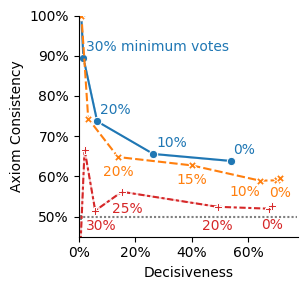

In [45]:
palette = color_palette()
palette[2] = "gray"
plot = FacetGrid(
    data=df_cs,
    margin_titles=True,
    xlim=(0, 0.775),
    ylim=(0.45, 1),
)
plot.map_dataframe(
    lineplot,
    x="decisiveness",
    y="consistency",
    hue="vote_type",
    style="vote_type",
    markers=True,
    palette=palette,
)
for (vote_type, df_vote_type), color in zip(
    df_cs.groupby("vote_type"), color_palette()
):
    if vote_type == "random":
        continue
    if vote_type == "new":
        vote_thresholds = [
            0.0,
            0.1,
            0.2,
            0.3,
            1.0,
        ]
    elif vote_type == "all":
        vote_thresholds = [
            0.0,
            0.1,
            0.15,
            0.2,
            1.0,
        ]
    elif vote_type == "old":
        vote_thresholds = [
            0.0,
            0.2,
            0.25,
            0.3,
        ]
    for x, y, vote_threshold in df_vote_type[
        ["decisiveness", "consistency", "vote_threshold"]
    ].values:
        if vote_threshold not in vote_thresholds:
            continue

        if vote_type == "new":
            verticalalignment = "bottom"
            horizontalalignment = "left"
            offsetx = 0.01
            offsety = 0.01
        elif vote_type == "all":
            verticalalignment = "top"
            horizontalalignment = "center"
            offsetx = 0.0
            offsety = -0.02
            if vote_threshold == 0.1:
                horizontalalignment = "right"
                offsety = -0.01
        elif vote_type == "old":
            verticalalignment = "top"
            horizontalalignment = "center"
            offsetx = 0.0
            offsety = -0.03
            if vote_threshold == 0.25:
                offsetx = 0.02
                offsety = -0.025
            elif vote_threshold == 0.3:
                offsetx = 0.02
                offsety = -0.02
        plot.ax.text(
            x=x,
            y=y,
            s=f"{vote_threshold:.0%}" + (" minimum votes" if vote_type == "new" and vote_threshold == 0.3 else ""),
            color=color,
            horizontalalignment=horizontalalignment,
            verticalalignment=verticalalignment,
            position=(x + offsetx, y + offsety),
        )

plot.ax.xaxis.set_major_formatter(PercentFormatter(xmax=1))
plot.ax.yaxis.set_major_formatter(PercentFormatter(xmax=1))
plot.set_titles(
    row_template="{row_name}",
    col_template="{col_name}",
)
plot.set_axis_labels("Decisiveness", "Axiom Consistency")
plot.savefig("../data/figures/figure-vote-axiom-decisiveness-consistency.pdf")
plot

/home/heinrich/Repositories/axioms/.venv/lib/python3.12/site-packages/seaborn/axisgrid.py:854: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  func(*plot_args, **plot_kwargs)


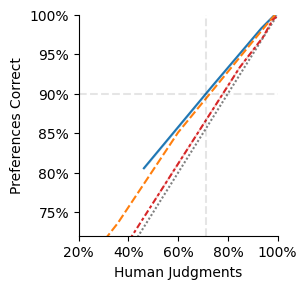

In [46]:
plot = FacetGrid(
    data=df_cs,
    margin_titles=True,
    xlim=(0.2, 1),
    ylim=(0.72, 1),
)
plot.map_dataframe(
    lineplot,
    x="human_judgment_effort",
    y="global_consistency_strict",
    hue="vote_type",
    style="vote_type",
    palette=palette,
)
plot.refline(
    y=0.90,
    linestyle="--",
    color="black",
    alpha=0.1,
)
plot.set_titles(
    row_template="{row_name}",
    col_template="{col_name}",
)
plot.refline(
    x=0.71,
    color="black",
    alpha=0.1,
)
plot.ax.xaxis.set_major_formatter(PercentFormatter(xmax=1))
plot.ax.yaxis.set_major_formatter(PercentFormatter(xmax=1, decimals=0))
plot.set_axis_labels("Human Judgments", "Preferences Correct")
plot.savefig("../data/figures/figure-vote-axiom-judgment-consistency.pdf")
plot

## Conflicting pairs

In [ ]:
data_conf = []

for oracle_name, oracle_data_run_type, oracle_preferences in rag_oracle_prefs:
    # Normalize preferences to -1, 0, 1.
    oracle_preferences = sign(oracle_preferences)

    stacked_axiom_preferences = stack(
        [
            axiom_preferences
            for _, axiom_prefs in (
                ("adapted retrieval axiom", rag_retrieval_axiom_prefs),
                ("generation-specific axiom", rag_generation_axiom_prefs),
            )
            for _, data_run_type, axiom_preferences in axiom_prefs
            if oracle_data_run_type == data_run_type
        ]
    )

    # Count how many axioms would have predicted the oracle preference.
    matching_axiom_preferences: NDArray = (
        stacked_axiom_preferences == oracle_preferences
    ).sum(axis=0)

    for orig_name, orig_data_run_type, orig_preferences in orig_axiom_prefs:
        if oracle_data_run_type != orig_data_run_type:
            continue

        # Normalize preferences to -1, 0, 1.
        orig_preferences = sign(orig_preferences)

        # Find conflicting pairs where the original ranking opposes the oracle ranking.
        conflicting_preferences_mask = (
            orig_preferences == (-1 * oracle_preferences)
        ) & (orig_preferences != 0)

        for input_index in range(orig_preferences.shape[0]):
            for output_index1 in range(orig_preferences.shape[-2]):
                for output_index2 in range(orig_preferences.shape[-1]):
                    if not conflicting_preferences_mask[
                        input_index, output_index1, output_index2
                    ]:
                        continue
                    if matching_axiom_preferences[
                        input_index, output_index1, output_index2
                    ] == 0:
                        continue
                    data_conf.append(
                        {
                            "data_run_type": oracle_data_run_type,
                            "oracle_name": oracle_name,
                            "axiom_name": orig_name,
                            "input_index": input_index,
                            "output_index1": output_index1,
                            "output_index2": output_index2,
                            "oracle_preference": oracle_preferences[
                                input_index, output_index1, output_index2
                            ],
                            "orig_preference": orig_preferences[
                                input_index, output_index1, output_index2
                            ],
                            "num_axiom_conflicts": matching_axiom_preferences[
                                input_index, output_index1, output_index2
                            ],
                        }
                    )
df_conf = DataFrame(data_conf)
df_conf = df_conf.sort_values("num_axiom_conflicts", ascending=False)
# df_conf

In [48]:
conf_data = to_inputs_outputs(read_rag_crowd_outputs_df())

In [ ]:
df_conf_overal = df_conf.copy()
df_conf_overal = df_conf_overal[df_conf_overal["oracle_name"] == "ORACLE-CROWD-OVERALL"]
df_conf_overal = df_conf_overal[df_conf_overal["num_axiom_conflicts"] > 5]
df_conf_overal["input"] = [
    conf_data[row["input_index"]][0]
    for _, row in df_conf_overal.iterrows()
]
df_conf_overal["input_text"] = [
    conf_data[row["input_index"]][0].text
    for _, row in df_conf_overal.iterrows()
]
df_conf_overal["output1"] = [
    conf_data[row["input_index"]][1][row["output_index1"]]
    for _, row in df_conf_overal.iterrows()
]
df_conf_overal["output1_text"] = [
    conf_data[row["input_index"]][1][row["output_index1"]].text
    for _, row in df_conf_overal.iterrows()
]
df_conf_overal["output2"] = [
    conf_data[row["input_index"]][1][row["output_index2"]]
    for _, row in df_conf_overal.iterrows()
]
df_conf_overal["output2_text"] = [
    conf_data[row["input_index"]][1][row["output_index2"]].text
    for _, row in df_conf_overal.iterrows()
]
df_conf_overal = df_conf_overal[df_conf_overal["orig_preference"] == 1]
df_conf_overal = df_conf_overal[~df_conf_overal["input_text"].str.contains("citizen")]
# df_conf_overal

In [ ]:
conf_example = df_conf_overal.iloc[1]
# conf_example

In [ ]:
conf_example_prefs = {}
for _, axiom_prefs in (
    ("adapted retrieval axiom", rag_retrieval_axiom_prefs),
    ("generation-specific axiom", rag_generation_axiom_prefs),
):
    for axiom_name, _, axiom_preferences in axiom_prefs:
        if axiom_name in ("GEN-REG", "GEN-AND", "GEN-DIV"):
            continue
        pref = axiom_preferences[conf_example["input_index"]][conf_example["output_index1"]][conf_example["output_index2"]]
        if pref != 0:
            conf_example_prefs[axiom_display_names[axiom_name]] = pref
            # print(axiom_name, pref)

In [56]:
def _format_response(response: str) -> str:
    response = (
        response.replace("\n", " ")
        .replace("  ", " ")
        .replace("%", r"\%")
        .replace("$", r"\$")
    )
    response = r"``" + response + r"''"
    response_words = response.split(" ")
    max_words = 38
    if len(response_words) > max_words:
        response = (
            " ".join(response_words[: int(max_words * 0.8)])
            + r" \textcolor{gray}{[...]} "
            + " ".join(response_words[int(-max_words * 0.2) :])
        )
    return response

In [ ]:
columns = [r"l", r"p{\responsewidth}", r"@{\qquad}"] + [r"c"] * len(conf_example_prefs)
print(r"\begin{tabular}{@{}" + "".join(columns) + r"@{}}")
print(r"  \toprule")
columns = [
    r"\multicolumn{2}{@{}p{\responsewidth}}{\textbf{Query} \quad " +
    conf_example["input"].id + r" \quad \query{" + conf_example["input"].text + r"}}",
] 
print(r"  " + r" & ".join(columns).strip() + r" \\[-2.2ex]")
columns = [
    r"\#",
    r"\textbf{Response}",
] + [r"\rotatebox{90}{\parbox{\axiomwidth}{\centering\textbf{" + axiom_name.strip() + r"}}}" for axiom_name, _ in conf_example_prefs.items()]
print(r"  " + r" & ".join(columns).strip() + r" \\")
print(r"  \midrule")
columns = [
    r"1",
     _format_response(conf_example["output1"].text) ,
] + [
    r"$\Uparrow$" if pref > 0 else r"$\Downarrow$"
    for _, pref in conf_example_prefs.items()
]
print(r"  " + r" & ".join(columns).strip() + r" \\")
columns = [
    r"2",
    _format_response(conf_example["output2"].text),
] + [
    r"$\Uparrow$" if pref < 0 else r"$\Downarrow$"
    for _, pref in conf_example_prefs.items()
]
print(r"  " + r" & ".join(columns).strip() + r" \\")
print(r"  \bottomrule")
print(r"\end{tabular}")